# Classification
## Chansu's Code Convert
### Model : VGG16
### Dataset : MNIST Grayscale Handwriting(1Channel)
#### MNIST 1채널 글씨체(Grayscale)
### Framework : Pytorch 1.9.0+cpu
### package list:
#### python 3.8.5
#### numpy 1.19.2
#### pytorch 1.9.0+cpu

## 부가자료
#### 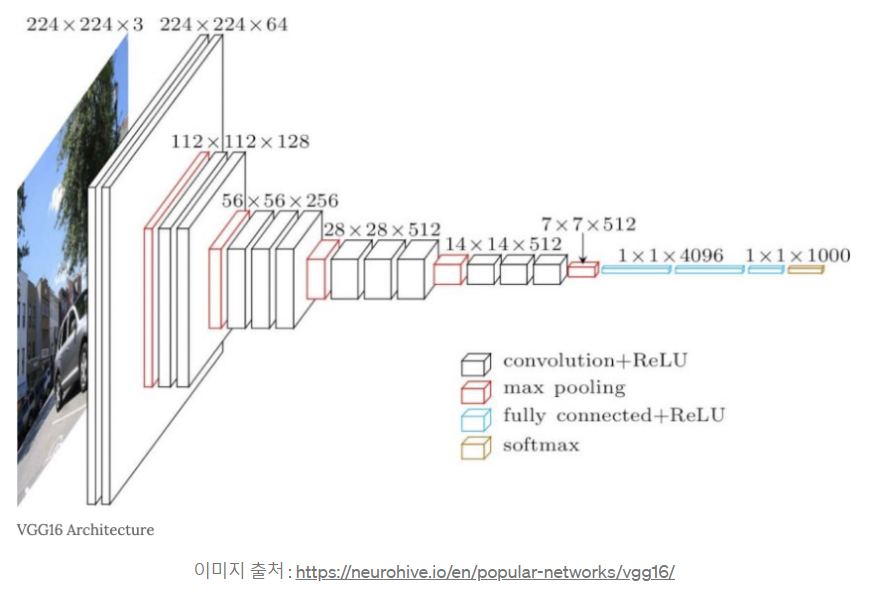
#### 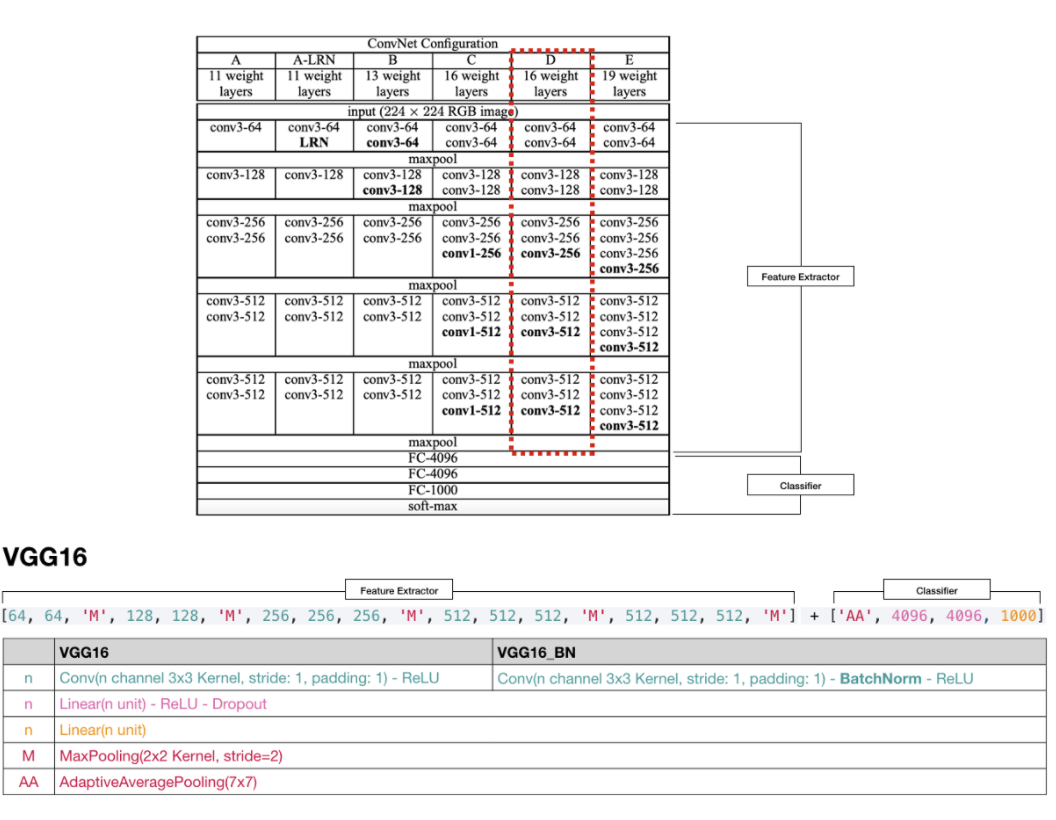
#### 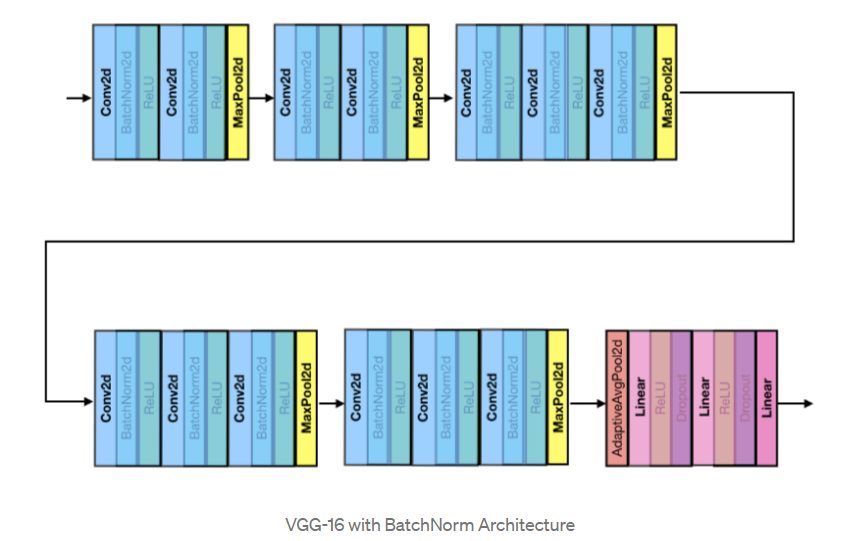

In [1]:
#Chansu's Code Convert
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cpu


In [2]:
# 데이터로드에 사용할 서브 프로세스 수
num_workers = 0
# 배치당 로드할 샘플 수
batch_size = 20

# 데이터를 Float Tensor형으로 변환합니다.
# transforms.Resize(224),
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))])

# 학습 및 테스트 데이터 로드
train_data = dsets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = dsets.MNIST(root='data', train=False, download=True, transform=transform)

# 학습 및 테스트 데이터 로더 준비
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

C:\Users\kgcom\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
#MLP
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(28 * 28, 512) #첫번째 Layer
#         self.fc2 = nn.Linear(512, 512) #두번째 Layer
#         self.fc3 = nn.Linear(512, 10) #세번째 Layer
#         self.dropout = nn.Dropout(0.2) #드롭아웃 Layer
#     def forward(self, x):
#         x = x.view(-1, 28 * 28)
#         x = F.relu(self.fc1(x))
#         return x

# model = Net()
# print(model)

#CNN
# class CNN(nn.Module):
    
#     def __init__(self):
#         super(CNN, self).__init__()
#         ## nn.Conv2d(입력 채널 수, 출력 채널 수, 커널 크기, 스트라이드)
#         conv1 = nn.Conv2d(1, 6, 5, 1) # 출력 크기 = 24*24, 채널 수 = 6
#         ## nn.MaxPool2d(커널 크기 및 스트라이드)
#         pool1 = nn.MaxPool2d(2) # 출력 크기 = 12*12
#         conv2 = nn.Conv2d(6, 16, 5, 1) # 출력 크기 = 8*8, 채널 수 = 16
#         pool2 = nn.MaxPool2d(2) # 출력 크기 = 4*4
        
#         self.conv_module = nn.Sequential(
#             conv1,
#             nn.ReLU(),
#             pool1,
#             conv2,
#             nn.ReLU(),
#             pool2
#         )
#         ## 채널 수 = 16, 출력 크기 = 4*4
#         self.fc1 = nn.Linear(16*4*4, 10)
        
        
#     def forward(self, x):
#         x = self.conv_module(x)
#         dim = 1
#         for d in x.size()[1:]: #FC Layer의 입력 크기를 구한다
#             dim = dim * d
#         x = x.view(-1, dim)
#         x = F.relu(self.fc1(x))
#         return x

# model = CNN()
# print(model)



#VGG16
class VGG(nn.Module):
    def __init__(self, features, num_classes=10, init_weights=True): 
        super(VGG, self).__init__() 
        self.features = features 
        self.avgpool = nn.AdaptiveAvgPool2d(7) 
        self.classifier = nn.Sequential( 
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True), 
            nn.Dropout(), 
            nn.Linear(4096, 1000),
            nn.ReLU(True), 
            nn.Dropout(), 
            nn.Linear(1000, num_classes),
        ) 
        
        if init_weights: 
            self._initialize_weights()
            
    def forward(self, x): 
        x = self.features(x) 
        x = self.avgpool(x) 
        x = x.view(x.size(0), -1) 
        x = self.classifier(x) 
        return x 

    def _initialize_weights(self): 
        for m in self.modules(): 
            if isinstance(m, nn.Conv2d): 
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
                if m.bias is not None: 
                    nn.init.constant_(m.bias, 0) 
            elif isinstance(m, nn.BatchNorm2d): 
                nn.init.constant_(m.weight, 1) 
                nn.init.constant_(m.bias, 0) 
            elif isinstance(m, nn.Linear): 
                nn.init.normal_(m.weight, 0, 0.01) 
                nn.init.constant_(m.bias, 0)

                                
def make_layers(cfg, batch_norm=False): 
    layers = [] 
    in_channels = 1 
    
    for v in cfg: 
        if v == 'M':# max pooling 
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)] 
        else: 
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1) 
            if batch_norm: 
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)] 
            else: 
                layers += [conv2d, nn.ReLU(inplace=True)] 
            in_channels = v 
    return nn.Sequential(*layers)

cfg = { 
    #8 + 3 =11 == vgg11 
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], 
    # 10 + 3 = vgg 13 
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    #13 + 3 = vgg 16 
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
#     [784, 256, 'M', 256, 256, 'M', 128, 128, 128, 'M', 64, 64, 64, 'M', 32, 32, 32, 'M'],
    # 16 +3 =vgg 19 
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
    }

feature = make_layers(cfg['D'], batch_norm=True)

model = VGG(feature, num_classes=10, init_weights=True)

model
model.to(device)



VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [4]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [5]:
from livelossplot import PlotLosses

n_epochs = 1 # 학습 epoch 지정
liveloss = PlotLosses()
model.train() 

for epoch in range(n_epochs):
    logs = {}
    train_loss = 0.0
    ###################
    #    모델 학습    #
    ###################
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        # 모든 optimizer 변수와 gradients를 초기화
        optimizer.zero_grad()
        # 정방향 학습 : 입력을 모델로 전달하여 예측된 출력 계산
        output = model(data).to(device)
        # Loss 계산
        loss = criterion(output, target)
        # 역전파 : 모델의 매개변수를 고려하여 loss의 gradients를 계산
        loss.backward()
        # 매개변수 업데이트
        optimizer.step()
        # 훈련 Loss 업데이트
        train_loss += loss.item()*data.size(0)
        
        visualize_loss = train_loss/len(train_loader.dataset)
        logs['train_loss'] = visualize_loss
    liveloss.update(logs)
    liveloss.draw()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, visualize_loss))

C:\Users\kgcom\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


KeyboardInterrupt: 

In [20]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data).to(device)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

RuntimeError: Given input size: (512x1x1). Calculated output size: (512x0x0). Output size is too small

C:\Users\kgcom\anaconda3\envs\healthhub\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


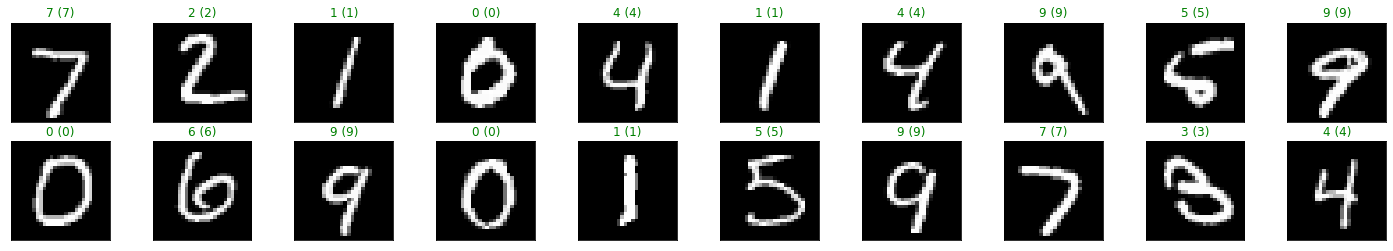

In [50]:
dataiter = iter(test_loader)

images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

output = model(images).to(device)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))